# Projet final Théorie du Deep Learning

Robin Charleuf, Gaspard Berthelier

## Main imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

## Datasets

In [2]:
#mnist

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1,parser='auto')
X_mnist, y_mnist = mnist.data / 255.0, mnist.target.astype(int)
print("Data shape:", X_mnist.shape)
mnist = None #free ram space

Data shape: (70000, 784)


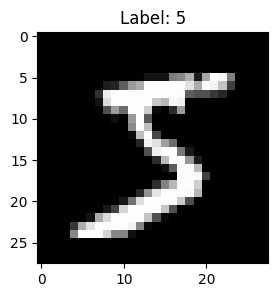

In [3]:
first_image = X_mnist.iloc[0].values.reshape(28, 28)

plt.figure(figsize=(3,3))
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {y_mnist[0]}")
plt.show();

In [4]:
#synthetic data

def get_synthetic(N=1000,d=20,sigma=10,noise=0.1):
  """returns random linear data + noise"""
  true_coeffs = np.random.randint(-10,10,size=d)/10
  X = np.array([np.random.normal(0,sigma,size=N) for k in range(d)]).T
  noise = np.random.uniform(0,noise,size=N)
  y = X @ true_coeffs + noise
  return X,y

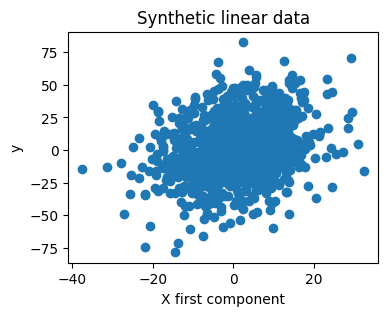

In [5]:
X_syn, y_syn = get_synthetic()
plt.figure(figsize=(4,3))
plt.scatter(X_syn[:,0],y_syn)
plt.title("Synthetic linear data")
plt.xlabel("X first component")
plt.ylabel("y")
plt.plot();

## Main Functions

In [6]:
def random_fourier_features(X,m,sigma=1e-1):
    """returns random features of dimension m"""
    W = np.random.normal(0,sigma,size=(X.shape[1],m))
    return np.real(np.exp(1j* np.dot(X,W)))

def get_dataset(X,y,m_rff=None,test_size=0.2,random_state=42,sigma=1e-1):
  """returns dataset with m features"""
  if m_rff:
    X = random_fourier_features(X,m_rff,sigma=sigma)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
  return X_train, X_test, y_train, y_test

Train shape :  (800, 100)


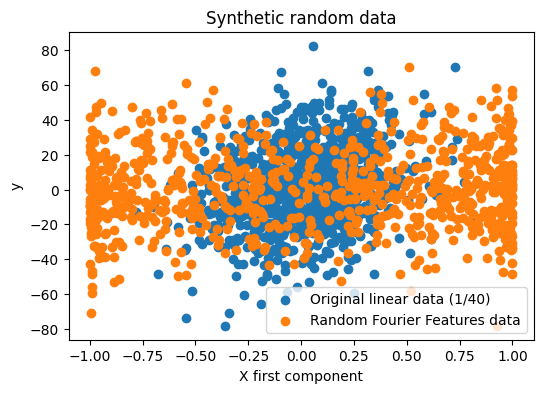

In [7]:
X_train, X_test, y_train, y_test = get_dataset(X_syn,y_syn,m_rff=100,sigma=10)
print("Train shape : ",X_train.shape)
plt.figure(figsize=(6,4))
plt.scatter(X_syn[:,0]/40,y_syn,label="Original linear data (1/40)")
plt.scatter(X_train[:,0],y_train,label="Random Fourier Features data")
plt.title("Synthetic random data")
plt.xlabel("X first component")
plt.ylabel("y")
plt.legend()
plt.plot();

In [8]:
def get_number_params_nn(X_train,m):
  """returns the number of features for given hidden dimensions m and input dim of NN"""
  dim = X_train.shape[1]
  if type(m)==int:
    params = (dim + 1) * m + (m + 1) * 10
  elif len(m)==2:
    params = (dim + 1) * m[0] + (m[0] + 1) * m[1] + m[1] * 10   #  = m0*(dim+1+m1) + m1(1+10)
  return params, params #for train and test

#projectors for linear regression models
def get_unique_projector(X_train): #unique solution
  return np.linalg.inv(X_train.T @ X_train) @ X_train.T

def get_min_norm_projector(X_train): #min norm solution
  return X_train.T @ np.linalg.inv(X_train @ X_train.T)

def get_coeffs(projector,y): #coeffs of linear regression
  return projector @ y_train

def get_x_coeff(x,projector): #s(x)
  return x @ projector

def get_effective_number_params_linear(X_train,X_test):
  """returns the effective number of parameters (according to paper) for linear model"""
  N = X_train.shape[0]
  M = X_train.shape[1]
  if M <= N :
    unique_projector = get_unique_projector(X_train)
    coeffs_train = (N/N)*np.sum(np.linalg.norm(get_x_coeff(X_train,unique_projector),axis=1))
    coeffs_test = (N/X_test.shape[0])*np.sum(np.linalg.norm(get_x_coeff(X_test,unique_projector),axis=1))
  else:
    min_norm_projector = get_min_norm_projector(X_train)
    coeffs_train = (N/N)*np.sum(np.linalg.norm(get_x_coeff(X_train,min_norm_projector),axis=1))
    coeffs_test = (N/X_test.shape[0])*np.sum(np.linalg.norm(get_x_coeff(X_test,min_norm_projector),axis=1))
  return coeffs_train, coeffs_test

def get_num_params(X_train, X_test, mode, m):
  if mode=="linear":
    return get_effective_number_params_linear(X_train, X_test)
  elif mode=="nn":
    return get_number_params_nn(X_train, m)

In [9]:
def one_trial(model, X_train, X_test, y_train, y_test, error, score, proba=False):
  """returns error (and score if specified) of model on given data"""
  trained_model = model.fit(X_train, y_train)
  if proba:
    y_pred_train = trained_model.predict_proba(X_train)
    y_pred_test = trained_model.predict_proba(X_test)
  else:
    y_pred_train = trained_model.predict(X_train)
    y_pred_test = trained_model.predict(X_test)
  errors_train = error(y_train,y_pred_train)
  errors_test = error(y_test,y_pred_test)
  if score:
    scores_train = score(y_train,y_pred_train)
    scores_test = score(y_test,y_pred_test)
  else:
    scores_train = None
    scores_test = None
  return errors_train, errors_test, scores_train, scores_test


def trials(model, X, y, error, score, n_random=5, m_rff=None,mode="linear",hidden_dim=None,proba=False):
  """returns error (and score if specified) of model on given data average over n_random experiments"""
  random_train_errors = []
  random_test_errors = []
  random_train_scores = []
  random_test_scores = []
  random_train_params = []
  random_test_params = []
  random_states = np.random.randint(1, 100, size=n_random)
  for k in range(n_random): #number of random repetitions
    X_train, X_test, y_train, y_test = get_dataset(X,y,m_rff,random_state=random_states[k])
    if mode=="linear":
      train_params, test_params = get_num_params(X_train, X_test, mode, m_rff)
    else:
      train_params, test_params = get_num_params(X_train, X_test, mode, hidden_dim)
    errors_train, errors_test, scores_train, scores_test = one_trial(model,X_train,X_test,y_train,y_test,error,score,proba=proba)
    random_train_errors.append(errors_train)
    random_test_errors.append(errors_test)
    random_train_params.append(train_params)
    random_test_params.append(test_params)
    if score:
      random_train_scores.append(scores_train)
      random_test_scores.append(scores_test)

  errors_train = np.mean(random_train_errors)
  errors_test = np.mean(random_test_errors)
  params_train = np.mean(random_train_params)
  params_test = np.mean(random_test_params)
  if score:
    scores_train = np.mean(random_train_scores)
    scores_test = np.mean(random_test_scores)
  else:
    scores_train = None
    scores_test = None
  return errors_train, errors_test, params_train, params_test, scores_train, scores_test

## Linear regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_expe(X,y,components_list,n_random=5):
  """returns scores of linear regression for m in components_list"""
  errors_train_list = []
  errors_test_list = []
  params_train_list = []
  params_test_list = []
  for m in tqdm(components_list):#number of input features
    reg = LinearRegression()
    mse = mean_squared_error
    errors_train, errors_test, params_train, params_test, scores_train, scores_test =  trials(reg, X, y, mse, None, n_random=n_random, m_rff=m)
    errors_train_list.append(errors_train)
    errors_test_list.append(errors_test)
    params_train_list.append(params_train)
    params_test_list.append(params_test)
  return errors_train_list, errors_test_list, params_train_list, params_test_list

def plot_linear_expe(X,y,components_list,n_random=5,ax0ylim=None,ax2ylim=None):
  """plots scores of linear regression function to components_list"""
  errors_train_list, errors_test_list, params_train_list, params_test_list = linear_expe(X,y,components_list,n_random=n_random)
  N = int(0.8*X.shape[0])
  idx_N = np.where(components_list==N)[0][0]
  fig, ax = plt.subplots(1,3,figsize=(15,4))

  ax[0].axvline(x=int(0.8*X.shape[0]), color='red', linestyle='--', label='N_train')
  ax[0].plot(components_list,errors_train_list,label="mse train")
  ax[0].plot(components_list,errors_test_list,label="mse test")
  ax[0].set_xlabel("Number of components")
  ax[0].set_ylabel("MSE")
  ax[0].set_xscale("log")
  ax[0].set_yscale("log")
  if ax0ylim:
    ax[0].set_ylim(ax0ylim)
  ax[0].legend(loc='upper left')

  ax[1].axhline(y=N, color='red', linestyle='--', label='N_train')
  ax[1].axvline(x=N, color='red', linestyle='--')
  ax[1].plot(components_list,params_train_list,label="params train")
  ax[1].plot(components_list,params_test_list,label="params test")
  ax[1].set_xscale("log")
  ax[1].set_yscale("log")
  ax[1].set_xlabel("Number of raw parameters")
  ax[1].set_ylabel("Effective parameters")
  ax[1].legend(loc='upper left')

  ax[2].axvline(x=N, color='red', linestyle='--', label='N_train')
  ax[2].scatter(params_train_list,np.log(np.array(errors_train_list)),color="C0",label="mse train")
  ax[2].scatter(params_test_list[0:idx_N],np.log(errors_test_list[:idx_N]),color="C1",label="mse test (m <= N)")
  ax[2].scatter(params_test_list[idx_N:],np.log(errors_test_list[idx_N:]),marker="x",color="red",label="mse test (m > N)")
  ax[2].set_xscale("log")
  ax[2].set_yscale("log")
  ax[2].set_xlabel("Number of effective parameters")
  ax[2].set_ylabel("MSE")
  if ax2ylim:
    ax[2].set_ylim(ax2ylim)
  ax[2].legend(loc='lower right')

  fig.suptitle("Double Descent with Linear Regression")
  fig.tight_layout()
  plt.show();

100%|██████████| 61/61 [03:53<00:00,  3.82s/it]


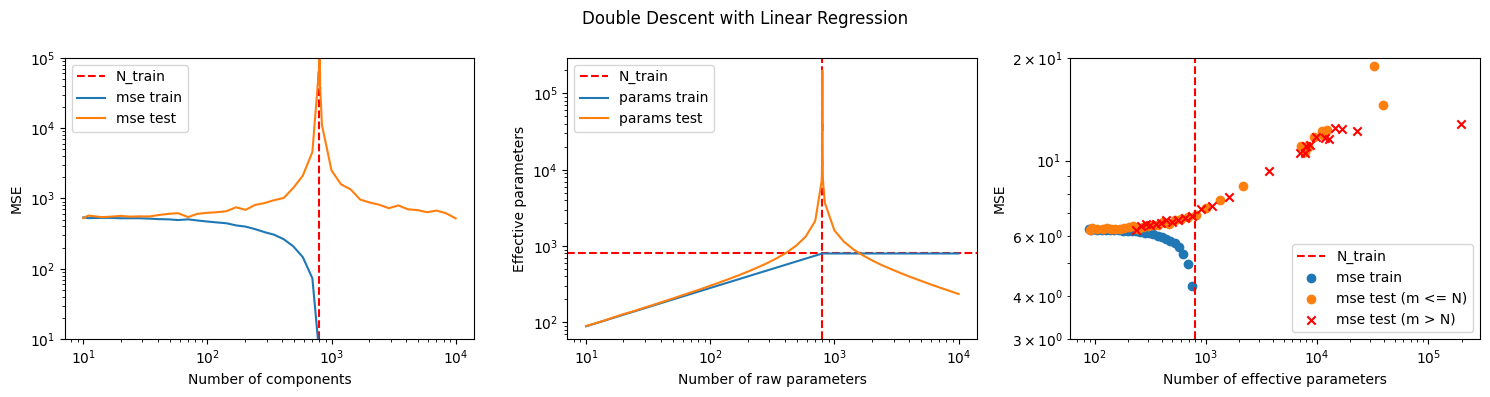

In [11]:
components_list = np.sort(list(np.logspace(1,4,40).astype(int))+[int(0.8*X_syn.shape[0])-k for k in range(11)]+[int(0.8*X_syn.shape[0])+k for k in range(1,11)])
plot_linear_expe(X_syn,y_syn,components_list,ax0ylim=[1e1,1e5],ax2ylim=[3e0,2e1])

100%|██████████| 61/61 [04:16<00:00,  4.20s/it]


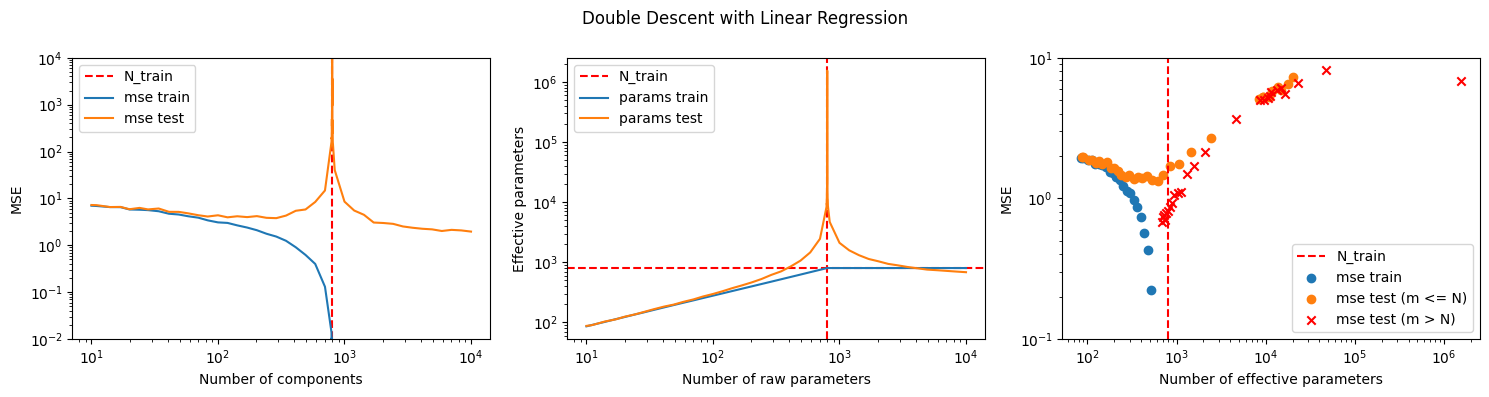

In [12]:
components_list = np.sort(list(np.logspace(1,4,40).astype(int))+[800-k for k in range(11)]+[800+k for k in range(1,11)])
plot_linear_expe(X_mnist[0:1000],y_mnist[0:1000],components_list,ax0ylim=[1e-2,1e4],ax2ylim=[1e-1,1e1])

## Neural Networks

In [13]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def nn_expe(X,y,m1_list,m2_list,n_iter=30,n_random=5,sizes=None):
  """returns scores of linear regression for m in components_list"""
  if m2_list:
    errors_train_list = {}
    errors_test_list = {}
    scores_train_list = {}
    scores_test_list = {}
    params_train_list = {}
    params_test_list = {}
    for m2 in m2_list:
      errors_train_list[m2] = []
      errors_test_list[m2] = []
      scores_train_list[m2] = []
      scores_test_list[m2] = []
      params_train_list[m2] = []
      params_test_list[m2] = []
      hidden_layers_list = [[m1,m2] for m1 in m1_list]
      for hidden_layer in tqdm(hidden_layers_list):
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer,activation="relu",random_state=1,max_iter=n_iter)
        loss = log_loss
        score = accuracy_score
        errors_train, errors_test, params_train, params_test, scores_train, scores_test =  trials(clf, X, y, loss, score, n_random=n_random, m_rff=None,mode="nn",hidden_dim=hidden_layer)
        errors_train_list[m2].append(errors_train)
        errors_test_list[m2].append(errors_test)
        params_train_list[m2].append(params_train)
        params_test_list[m2].append(params_test)
        scores_train_list[m2].append(scores_train)
        scores_test_list[m2].append(scores_test)
  elif sizes:
    errors_train_list = {}
    errors_test_list = {}
    scores_train_list = {}
    scores_test_list = {}
    params_train_list = {}
    params_test_list = {}
    for size in sizes:
      errors_train_list[size] = []
      errors_test_list[size] = []
      scores_train_list[size] = []
      scores_test_list[size] = []
      params_train_list[size] = []
      params_test_list[size] = []
      hidden_layers_list = m1_list.copy()
      for hidden_layer in tqdm(hidden_layers_list):
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer,activation="relu",random_state=1,max_iter=n_iter)
        loss = log_loss
        score = accuracy_score
        errors_train, errors_test, params_train, params_test, scores_train, scores_test =  trials(clf, X[0:size], y[0:size], loss, score, n_random=n_random, m_rff=None,mode="nn",hidden_dim=hidden_layer)
        errors_train_list[size].append(errors_train)
        errors_test_list[size].append(errors_test)
        params_train_list[size].append(params_train)
        params_test_list[size].append(params_test)
        scores_train_list[size].append(scores_train)
        scores_test_list[size].append(scores_test)
  else:
    errors_train_list = []
    errors_test_list = []
    scores_train_list = []
    scores_test_list = []
    params_train_list = []
    params_test_list = []
    hidden_layers_list = m1_list.copy()
    for hidden_layer in tqdm(hidden_layers_list):
      clf = MLPClassifier(hidden_layer_sizes=hidden_layer,activation="relu",random_state=1,max_iter=n_iter)
      loss = log_loss
      score = accuracy_score
      errors_train, errors_test, params_train, params_test, scores_train, scores_test =  trials(clf, X, y, loss, score, n_random=n_random, m_rff=None,mode="nn",hidden_dim=hidden_layer)
      errors_train_list.append(errors_train)
      errors_test_list.append(errors_test)
      params_train_list.append(params_train)
      params_test_list.append(params_test)
      scores_train_list.append(scores_train)
      scores_test_list.append(scores_test)

  return errors_train_list, errors_test_list, scores_train_list, scores_test_list, params_train_list, params_test_list


def plot_nn_expe(X,y,m1_list,m2_list,n_iter=30,n_random=5,sizes=None):
  """plots experiment with m1 and m2 hidden dims and n_samples=size"""

  errors_train_list, errors_test_list, scores_train_list, scores_test_list, params_train_list, params_test_list = nn_expe(X,y,m1_list,m2_list,n_iter=n_iter,n_random=n_random,sizes=sizes)

  fig, ax = plt.subplots(1, 4, figsize=(15, 4))

  if m2_list:
    for i, m2 in enumerate(m2_list):
      ax[0].plot(params_train_list[m2], scores_train_list[m2], linestyle='-', label=f'Train m2={m2}', color=f'C{i}')
      if len(m2_list)==1:
        ax[0].plot(params_train_list[m2], scores_test_list[m2], linestyle='--', label=f'Test m2={m2}', color=f'C{i}')
      else:
        ax[0].plot(params_train_list[m2], scores_test_list[m2], linestyle='--', color=f'C{i}')
      ax[1].plot(m1_list, params_train_list[m2],label=f"Total parameters for m2={m2}", color=f"C{i}")
      ax[2].plot(params_train_list[m2], errors_train_list[m2], linestyle='-', label=f'Train m2={m2}', color=f'C{i}')
      ax[3].plot(params_train_list[m2], errors_test_list[m2], linestyle='--', label=f'Test m2={m2}', color=f'C{i}')

  elif sizes:
    for i, size in enumerate(sizes):
      ax[0].plot(params_train_list[size], scores_train_list[size], linestyle='-', label=f'Train samples={size}', color=f'C{i}')
      ax[0].plot(params_train_list[size], scores_test_list[size], linestyle='--',color=f'C{i}')
      ax[1].plot(m1_list, params_train_list[size], color=f"C{i}")
      ax[1].axhline(y=int(0.8*size), linestyle='--', label=f'n_samples = {size}', color=f'C{i}')
      ax[2].plot(params_train_list[size], errors_train_list[size], linestyle='-', label=f'Train', color=f'C{i}')
      ax[3].plot(params_train_list[size], errors_test_list[size], linestyle='--', label=f'Test', color=f'C{i}')

  else:
      ax[0].plot(params_train_list, scores_train_list, linestyle='-', marker='o', label=f'Train')
      ax[0].plot(params_train_list, scores_test_list, linestyle='--', marker='o',label=f'Test')
      ax[1].plot(m1_list, params_train_list,label=f"Total parameters")
      ax[2].plot(params_train_list, errors_train_list, linestyle='-', marker='o', label=f'Train')
      ax[3].plot(params_train_list, errors_test_list, linestyle='--', marker='o', label=f'Test')


  ax[0].set_xscale("log")
  ax[0].set_ylim([0, 1])
  ax[0].set_xlabel("Number of parameters")
  ax[0].set_ylabel("Accuracy")
  if not sizes:
    ax[0].axvline(x=int(0.8*X.shape[0]), color='red', linestyle='--', label='n_samples')
  ax[0].legend()

  ax[1].set_xscale("log")
  ax[1].set_yscale("log")
  ax[1].set_ylabel("Total number of parameters")
  ax[1].set_xlabel("Number of hidden parameters (layer 1)")
  if not sizes:
    ax[1].axhline(y=int(0.8*X.shape[0]), color='red', linestyle='--', label='n_samples')
  ax[1].legend()

  ax[2].set_xscale("log")
  ax[2].set_yscale("log")
  ax[2].set_xlabel("Number of parameters")
  ax[2].set_ylabel("Train MSE Loss")
  if not sizes:
    ax[2].axvline(x=int(0.8*X.shape[0]), color='red', linestyle='--', label='n_samples')
  ax[2].legend()

  ax[3].set_xscale("log")
  ax[3].set_xlabel("Number of parameters")
  ax[3].set_ylabel("Test MSE Loss")
  if not sizes:
    ax[3].axvline(x=int(0.8*X.shape[0]), color='red', linestyle='--', label='n_samples')
  ax[3].legend()

  plt.tight_layout()
  plt.show();

100%|██████████| 17/17 [27:12<00:00, 96.04s/it] 


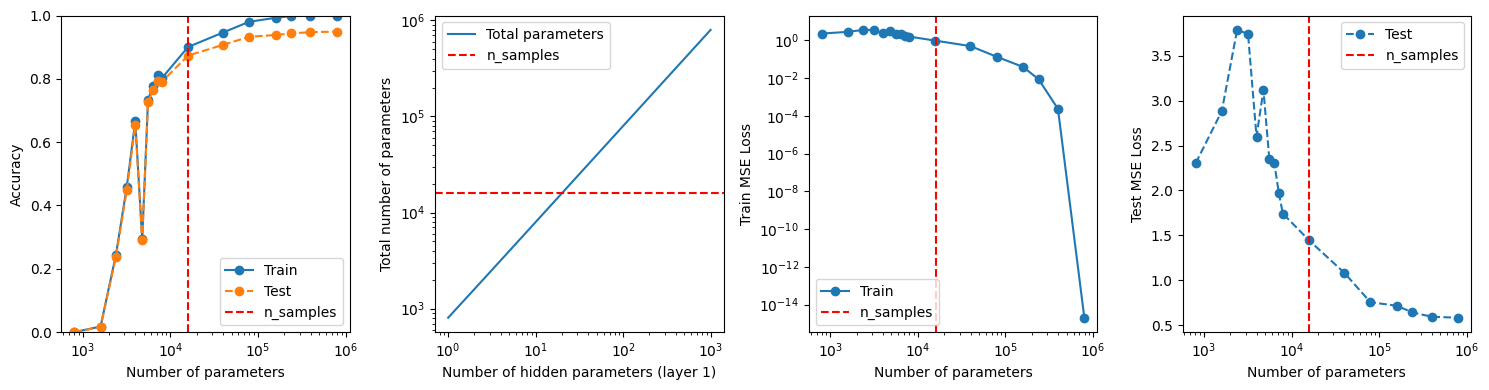

In [14]:
m2_list = None
m1_list = list(range(1,10))+[10,20,50,100,200,300,500,1000]
plot_nn_expe(np.array(X_mnist[0:20000]),np.array(pd.get_dummies(y_mnist[0:20000])),m1_list,m2_list,n_iter=30,n_random=5)

100%|██████████| 17/17 [13:39<00:00, 48.21s/it] 


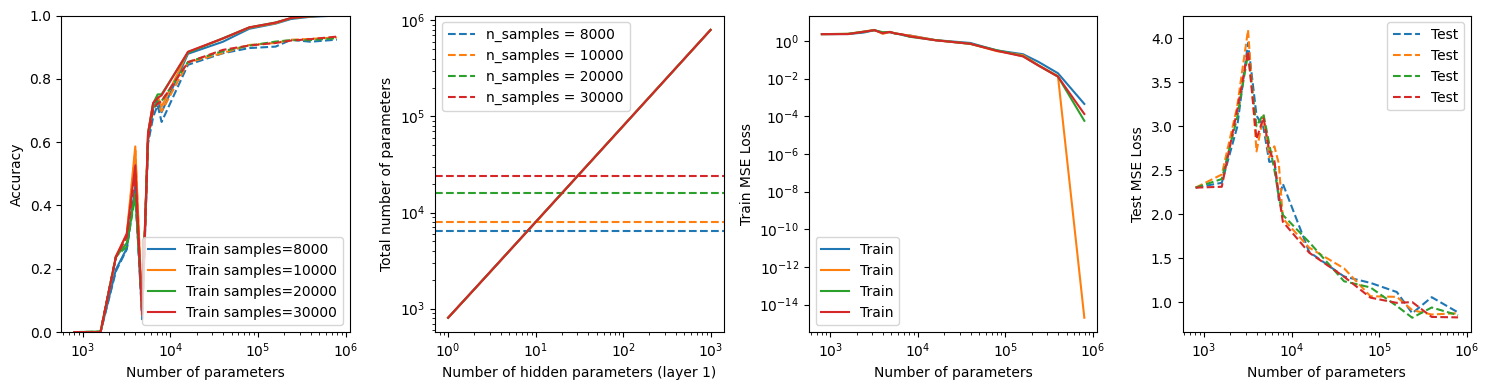

In [15]:
m2_list = None
m1_list = list(range(1,10))+[10,20,50,100,200,300,500,1000]
plot_nn_expe(np.array(X_mnist[0:10000]),np.array(pd.get_dummies(y_mnist[0:10000])),m1_list,m2_list,n_iter=30,n_random=5,sizes=[8000,10000,20000,30000])

100%|██████████| 16/16 [06:31<00:00, 24.46s/it]


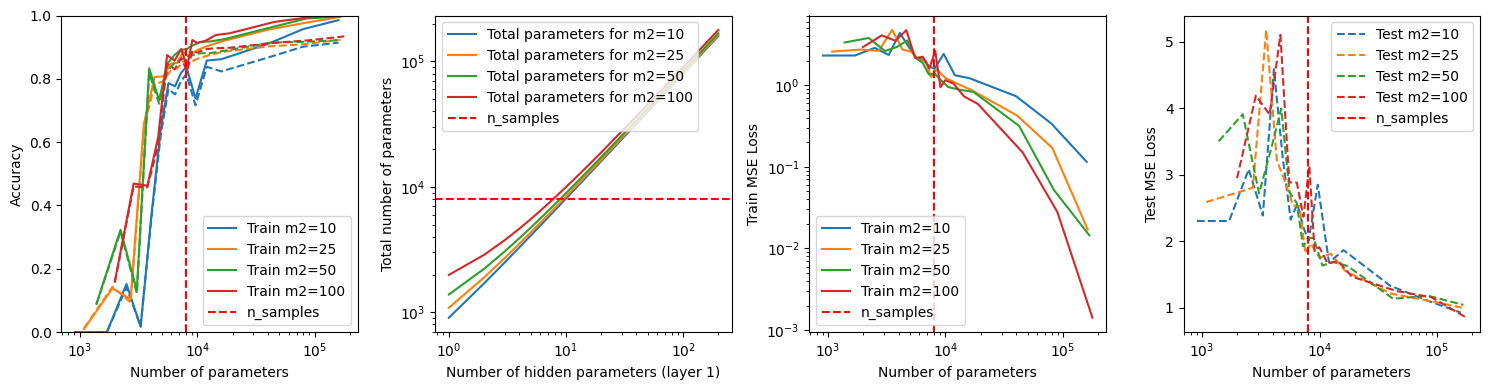

In [16]:
m2_list = [10,25,50,100]
m1_list = list(range(1,10))+[10,12,15,20,50,100,200]
plot_nn_expe(np.array(X_mnist[0:10000]),np.array(pd.get_dummies(y_mnist[0:10000])), m1_list,m2_list,n_iter=30,n_random=5)

100%|██████████| 17/17 [1:08:02<00:00, 240.17s/it]


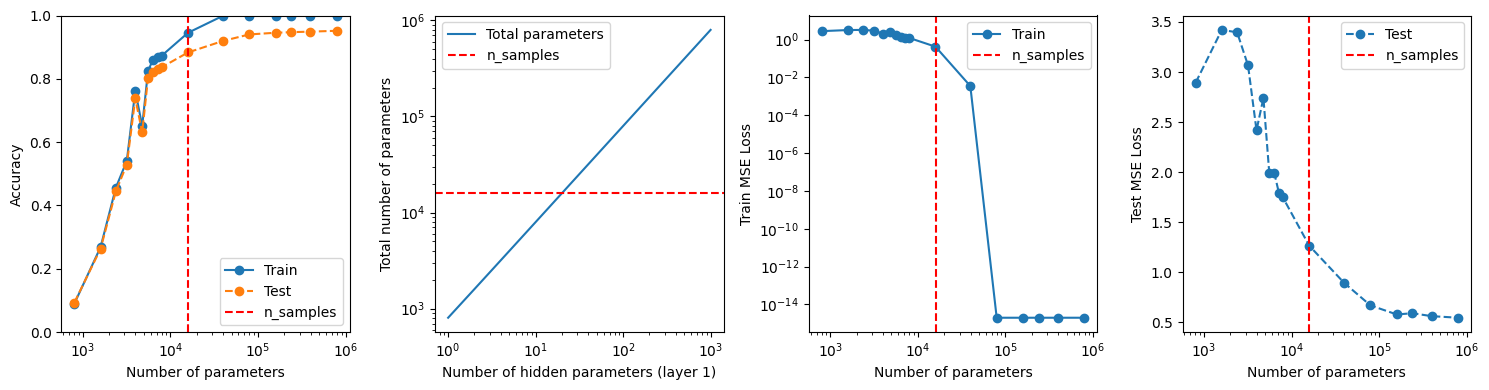

In [17]:
m2_list = None
m1_list = list(range(1,10))+[10,20,50,100,200,300,500,1000]
plot_nn_expe(np.array(X_mnist[0:20000]),np.array(pd.get_dummies(y_mnist[0:20000])),m1_list,m2_list,n_iter=100,n_random=5)

100%|██████████| 17/17 [1:41:46<00:00, 359.23s/it]


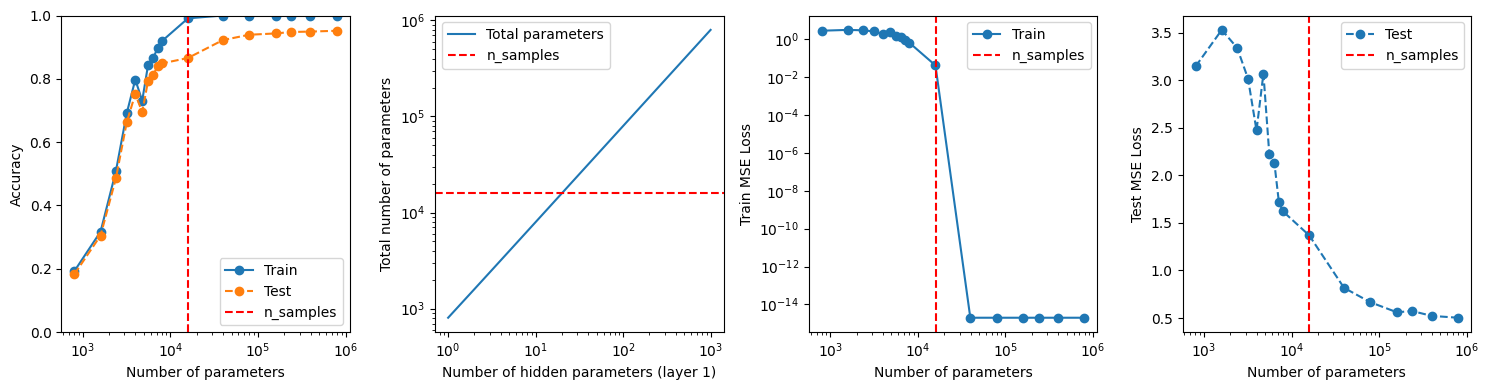

In [18]:
m2_list = None
m1_list = list(range(1,10))+[10,20,50,100,200,300,500,1000]
plot_nn_expe(np.array(X_mnist[0:20000]),np.array(pd.get_dummies(y_mnist[0:20000])),m1_list,m2_list,n_iter=300,n_random=5)